In [1]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score

In [2]:
train_dir = "D:\Kode\dataset-original\dataset-original"
print(len(train_dir))

41


In [3]:
os.listdir(train_dir)

['.DS_Store', 'cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

# Preprocessing

In [4]:
file_name = []
tag = []
full_path = []
for path, subdirs, files in os.walk(train_dir):
    for name in files:
        full_path.append(os.path.join(path, name))
        tag.append(path.split('/')[-1])
        file_name.append(name)

In [5]:
df = pd.DataFrame({"path":full_path,'file_name':file_name,"tag":tag})
df.groupby(['tag']).size()

tag
D:\Kode\dataset-original\dataset-original                1
D:\Kode\dataset-original\dataset-original\cardboard    404
D:\Kode\dataset-original\dataset-original\glass        502
D:\Kode\dataset-original\dataset-original\metal        411
D:\Kode\dataset-original\dataset-original\paper        595
D:\Kode\dataset-original\dataset-original\plastic      483
D:\Kode\dataset-original\dataset-original\trash        137
dtype: int64

In [6]:
image_size = 224
batch_size = 128

# Create an ImageDataGenerator for the training dataset with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 20% of the data will be used for validation
)

# Create a training data generator
train_data = train_datagen.flow_from_directory(
    batch_size=batch_size,
    directory=train_dir,
    shuffle=True,
    target_size=(image_size, image_size),
    class_mode="categorical",
    subset="training"  # Use this subset for training
)

# Create a validation data generator
validation_data = train_datagen.flow_from_directory(
    batch_size=batch_size,
    directory=train_dir,
    shuffle=False,  # Set to False for validation
    target_size=(image_size, image_size),
    class_mode="categorical",
    subset="validation"  # Use this subset for validation
)


# Check the number of samples in training and validation sets
print("Number of training samples:", len(train_data))
print("Number of validation samples:", len(validation_data))

Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.
Number of training samples: 16
Number of validation samples: 4


# Exploratory Image Analysis

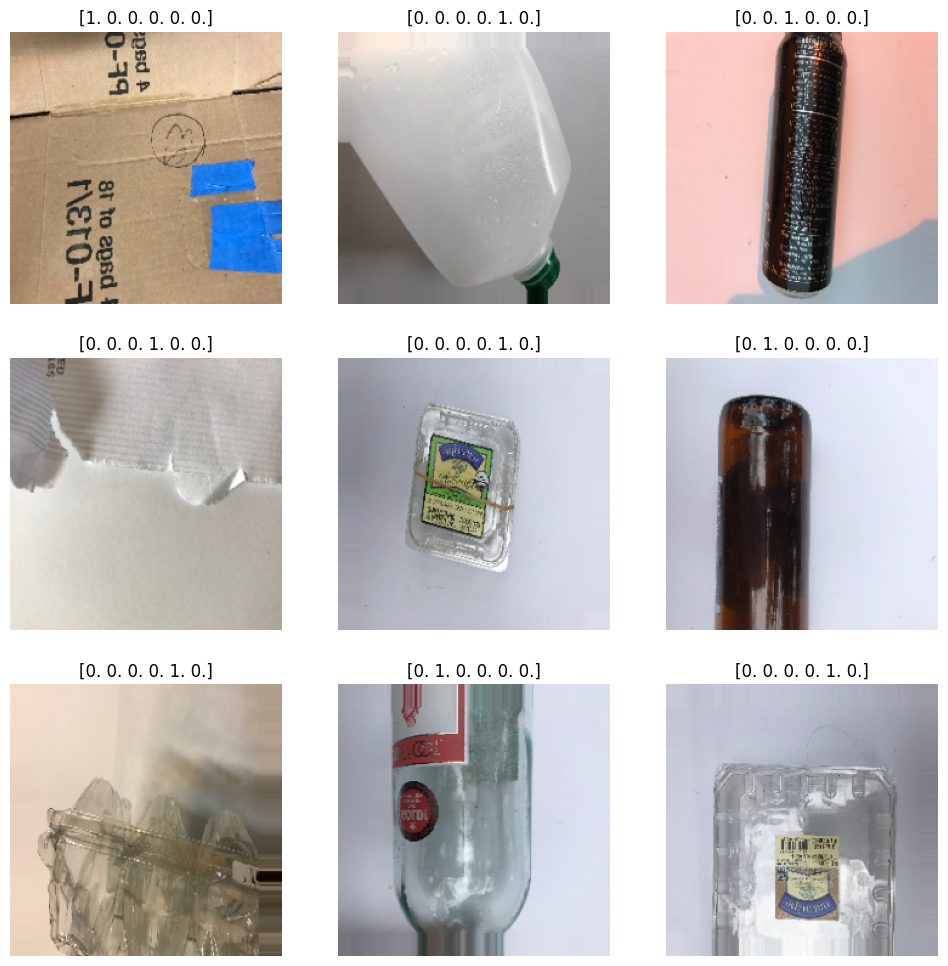

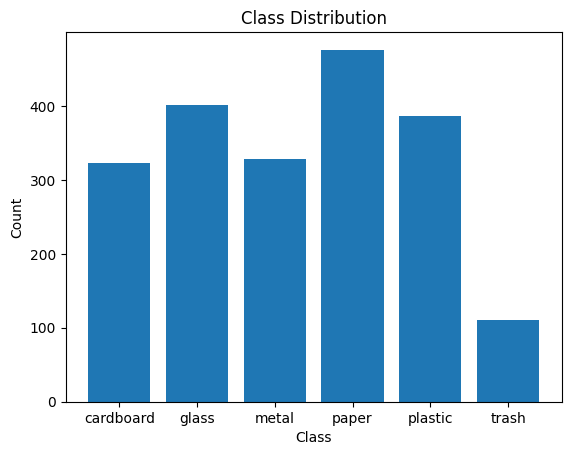

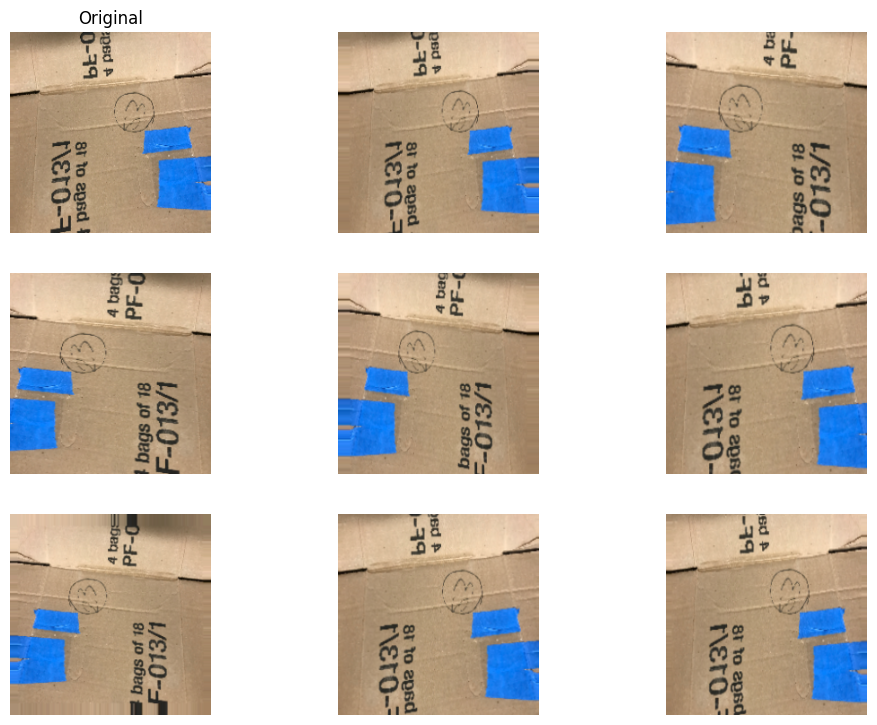

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display a grid of images
def plot_images(images, labels, n=9):
    plt.figure(figsize=(12, 12))
    for i in range(n):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(labels[i])
        plt.axis('off')
    plt.show()

# Get a batch of images and labels from the training data generator
x_batch, y_batch = train_data.__next__()

# Display a grid of sample images
plot_images(x_batch[:9], y_batch[:9])

# Visualize class distribution
class_labels = train_data.class_indices.keys()
class_counts = []
for class_name in class_labels:
    class_count = (train_data.classes == train_data.class_indices[class_name]).sum()
    class_counts.append(class_count)

plt.bar(class_labels, class_counts)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

# Generate augmented images from a single image
img = x_batch[0]
augmented_images = [train_datagen.random_transform(img) for _ in range(9)]

# Display the original and augmented images
plt.figure(figsize=(12, 12))

# Plot the original image in the first subplot
plt.subplot(4, 3, 1)  # 4 rows, 3 columns, starting from subplot 1
plt.imshow(img)
plt.title('Original')
plt.axis('off')

# Loop through the remaining 8 augmented images
for i in range(8):
    plt.subplot(4, 3, i + 2)  # Starting from subplot 2 (skipping the first)
    plt.imshow(augmented_images[i])
    plt.axis('off')

plt.show()

# Modelling

In [58]:
class Priyo_NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        # Inisialisasi bobot dan bias secara acak
        self.weights1 = np.random.randn(input_size, hidden_size)
        self.bias1 = np.zeros(hidden_size)
        self.weights2 = np.random.randn(hidden_size, output_size)
        self.bias2 = np.zeros(output_size)

    def sigmoid(self, x):
        clipped_x = np.clip(x, -5, 5)  # Clip values between -5 and 5
        return 1 / (1 + np.exp(-clipped_x))

    def forward(self, X):
        # Perhitungan forward propagation
        self.z1 = np.dot(X, self.weights1) + self.bias1
        self.a1 = self.sigmoid(self.z1)
        self.z2 = np.dot(self.a1, self.weights2) + self.bias2
        self.a2 = self.sigmoid(self.z2)
        return self.a2

    def backward(self, X, y, learning_rate):
        m = X.shape[0]
        dZ2 = self.a2 - y
        dW2 = 1/m * np.dot(self.a1.T, dZ2)
        db2 = 1/m * np.sum(dZ2, axis=0)
        dZ1 = np.dot(dZ2, self.weights2.T) * (1 - self.a1) * self.a1
        dW1 = 1/m * np.dot(X.T, dZ1)
        db1 = 1/m * np.sum(dZ1, axis=0)
    
        return dW1, db1, dW2, db2

    def train(self, X, y, epochs, learning_rate, beta1=0.9, beta2=0.999, epsilon=1e-8):
        m = X.shape[0]
    
        # Initialize moments for Adam
        v_dw1, v_db1, v_dw2, v_db2 = np.zeros_like(self.weights1), np.zeros_like(self.bias1), np.zeros_like(self.weights2), np.zeros_like(self.bias2)
        s_dw1, s_db1, s_dw2, s_db2 = np.zeros_like(self.weights1), np.zeros_like(self.bias1), np.zeros_like(self.weights2), np.zeros_like(self.bias2)
        t = 0
    
        for epoch in range(epochs):
            self.forward(X)
            dW1, db1, dW2, db2 = self.backward(X, y, learning_rate)

            # Update weights and biases using Adam
            t += 1
            
            # Update biased first moment estimate
            v_dw1 = beta1 * v_dw1 + (1 - beta1) * dW1
            v_db1 = beta1 * v_db1 + (1 - beta1) * db1
            v_dw2 = beta1 * v_dw2 + (1 - beta1) * dW2
            v_db2 = beta1 * v_db2 + (1 - beta1) * db2

            # Update biased second raw moment estimate
            s_dw1 = beta2 * s_dw1 + (1 - beta2) * np.square(dW1)
            s_db1 = beta2 * s_db1 + (1 - beta2) * np.square(db1)
            s_dw2 = beta2 * s_dw2 + (1 - beta2) * np.square(dW2)
            s_db2 = beta2 * s_db2 + (1 - beta2) * np.square(db2)
            
            # Compute bias-corrected first moment estimate
            v_dw1_corrected = v_dw1 / (1 - beta1**t)
            v_db1_corrected = v_db1 / (1 - beta1**t)
            v_dw2_corrected = v_dw2 / (1 - beta1**t)
            v_db2_corrected = v_db2 / (1 - beta1**t)
            
            # Compute bias-corrected second raw moment estimate
            s_dw1_corrected = s_dw1 / (1 - beta2**t)
            s_db1_corrected = s_db1 / (1 - beta2**t)
            s_dw2_corrected = s_dw2 / (1 - beta2**t)
            s_db2_corrected = s_db2 / (1 - beta2**t)
            
            # Update weights and biases
            self.weights1 -= learning_rate * v_dw1_corrected / (np.sqrt(s_dw1_corrected) + epsilon)
            self.bias1 -= learning_rate * v_db1_corrected / (np.sqrt(s_db1_corrected) + epsilon)
            self.weights2 -= learning_rate * v_dw2_corrected / (np.sqrt(s_dw2_corrected) + epsilon)
            self.bias2 -= learning_rate * v_db2_corrected / (np.sqrt(s_db2_corrected) + epsilon)

            if (epoch+1) % 100 == 0:
                print(f'Epoch {epoch+1}/{epochs}, loss: {self.loss(y, self.a2)}')

    def loss(self, y_true, y_pred):
        # Fungsi loss (misalnya binary cross-entropy)
        return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

    def predict(self, X):
        # Prediksi menggunakan forward propagation
        y_pred = self.forward(X)
        # Rounding untuk klasifikasi biner
        y_pred = np.round(y_pred)
        return y_pred

    def accuracy(self, X, y):
        # Hitung akurasi
        y_pred = self.predict(X)
        accuracy = np.mean(y_pred == y)
        return accuracy

In [59]:
model = Priyo_NeuralNetwork(input_size=image_size*image_size*3, hidden_size=64, output_size=6)

In [ ]:
for epoch in range(5):
    for X_batch, y_batch in train_data:
        # Reshape X_batch to (batch_size, -1) where -1 infers the total number of elements
        X_batch_reshaped = X_batch.reshape(X_batch.shape[0], -1)
        model.train(X_batch_reshaped, y_batch, epochs=1, learning_rate=0.01)  # Adjust epochs within loop
        # Optionally evaluate on validation data using validation_data generator
    print(f"Epoch {epoch+1}/{epochs} completed.")

In [ ]:
y_pred = model.predict(validation_data)
print(f"Predicted label for new data: {y_pred[0]}")

# Evaluate accuracy on test data
for X_new, y_new in validation_data:
    accuracy = model.accuracy(X_new, y_new)
    print(f"Accuracy on testing set: {accuracy}")